In [1]:
library(tidyverse)
library(pbapply)
library(parallel)
library(assertthat)
library(sf)
library(pROC)
library(patchwork)
library(vroom)
library(yardstick)
library(rmapshaper)
library(here)
#source('R/utils.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘purrr’ was built under R version 3.6.3”
Warning message:
“package ‘stringr’ was built under R version 3.6.3”
Warning message:
“package ‘forcats’ was built under R version 3.6.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘assertthat’


The following object is masked from ‘package:tibble’:

    has_name


Linking to GEOS 3.7.2dev, GDAL 2.4.2, PROJ 6.1.0

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


For binary classification, the first factor level is assumed to be the event.
Use the argument `event_lev

In [2]:
loadRData <- function(fileName){
#loads an RData file, and returns it
    load(fileName)
    get(ls()[ls() != "fileName"])
}

In [4]:
gru_1 <- loadRData('ll_dfs_gru_1.RData')

In [7]:
str(gru_1)

List of 649
 $ : tibble [71,737 × 13] (S3: tbl_df/tbl/data.frame)
  ..$ sp.bbs          : chr [1:71737] "6560" "6560" "6560" "6560" ...
  ..$ route_id        : chr [1:71737] "02_001" "02_001" "02_001" "02_001" ...
  ..$ group           : chr [1:71737] "train" "train" "train" "train" ...
  ..$ year            : chr [1:71737] "1997" "1998" "1999" "2000" ...
  ..$ gamma           : num [1:71737] 0.001661 0.000588 0.000543 0.000534 0.000533 ...
  ..$ p               : num [1:71737] 0.0559 0.0447 0.0487 0.0468 0.0447 ...
  ..$ phi             : num [1:71737] 0.872 0.897 0.894 0.89 0.888 ...
  ..$ psi             : num [1:71737] 0.00727 0.00799 0.00775 0.00747 0.00718 ...
  ..$ marginal_pred   : num [1:71737] 0.0218 0.016 0.0155 0.0149 0.0144 ...
  ..$ conditional_pred: num [1:71737] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ conditional_lo  : num [1:71737] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ conditional_hi  : num [1:71737] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y               : num [1:71737] 0 0 0 0 0 0 0 0 0 0 ...
 

In [5]:
head(gru_1, 2)

sp.bbs,route_id,group,year,gamma,p,phi,psi,marginal_pred,conditional_pred,conditional_lo,conditional_hi,y
6560,02_001,train,1997,0.0016608791,0.05588814,0.8720089,0.007271480,0.021814439,0,0,0,0
6560,02_001,train,1998,0.0005882140,0.04465641,0.8967487,0.007989597,0.015979194,0,0,0,0
6560,02_001,train,1999,0.0005431159,0.04874570,0.8942094,0.007748175,0.015496350,0,0,0,0
6560,02_001,train,2000,0.0005343818,0.04675889,0.8904408,0.007467399,0.014934798,0,0,0,0
6560,02_001,train,2001,0.0005326728,0.04465525,0.8877595,0.007179668,0.014359336,0,0,0,0
6560,02_001,train,2002,0.0005312458,0.05042050,0.8859020,0.006902667,0.013805335,0,0,0,0
6560,02_001,train,2003,0.0005297623,0.04579214,0.8845340,0.006642665,0.013285330,0,0,0,0
6560,02_001,train,2004,0.0005283382,0.04456664,0.8834660,0.006401907,0.012803813,0,0,0,0
6560,02_001,train,2005,0.0005270308,0.04648620,0.8825994,0.006180822,0.012361645,0,0,0,0
6560,02_001,train,2006,0.0005258540,0.04396445,0.8818808,0.005978963,0.011957926,0,0,0,0


In [8]:
# To evaluate predictive performance, remove years with no surveys
q_df <- gru_1 %>%
  bind_rows %>%
  filter(!is.na(y), group == 'validation')

# compute prob of zero and prob of nonzero
q_df <- q_df %>%
  mutate(pr_zero = (1 - psi) + psi * (1 - p)^50, 
         estimate = 1 - pr_zero, 
         truth = factor(ifelse(y > 0, 'detected', 'not detected')))

roc_df_validation <- q_df %>%
  filter(group == 'validation') %>%
  group_by(route_id) %>%
  roc_curve(truth, estimate) %>%
  ungroup

# roc_df_training <- q_df %>%
#   filter(group == 'training') %>%
#   group_by(route_id) %>%
#   roc_curve(truth, estimate) %>%
#   ungroup

auc_df_validation <- q_df %>%
  filter(group == 'validation') %>%
  group_by(route_id) %>%
  roc_auc(truth, estimate)

# auc_df_training <- q_df %>%
#   filter(group == 'training') %>%
#   group_by(route_id) %>%
#   roc_auc(truth, estimate)

In [9]:
head(q_df)

sp.bbs,route_id,group,year,gamma,p,phi,psi,marginal_pred,conditional_pred,conditional_lo,conditional_hi,y,pr_zero,estimate,truth
6560,02_041,validation,1997,0.0022502549,0.06039236,0.8729660,0.007511713,0.02253514,0,0,0,0,0.9928218,0.007178236,not detected
6560,02_041,validation,1999,0.0006972495,0.05444130,0.8886182,0.008625621,0.02587686,0,0,0,0,0.9918994,0.008100553,not detected
6560,02_041,validation,2000,0.0006840361,0.05322141,0.8853529,0.008356119,0.02506836,0,0,0,0,0.9921864,0.007813587,not detected
6560,02_041,validation,2001,0.0006827312,0.05027277,0.8828050,0.008076434,0.01615287,0,0,0,0,0.9925361,0.007463852,not detected
6560,02_041,validation,2002,0.0006828211,0.05492648,0.8809202,0.007807134,0.02342140,0,0,0,0,0.9926561,0.007343931,not detected
6560,02_041,validation,2003,0.0006828921,0.05245989,0.8794804,0.007554953,0.01510991,0,0,0,0,0.9929557,0.007044316,not detected


In [10]:
print(head(roc_df_validation))
# print(head(roc_df_training))

# A tibble: 6 x 4
  route_id  .threshold specificity sensitivity
  <chr>          <dbl>       <dbl>       <dbl>
1 02_041   -Inf           0                  1
2 02_041      1.18e-10    0                  1
3 02_041      2.26e-10    0.000274           1
4 02_041      2.73e-10    0.000548           1
5 02_041      7.80e-10    0.000822           1
6 02_041      7.81e-10    0.00110            1


In [11]:
print(head(auc_df_validation))
# print(head(auc_df_training))

# A tibble: 6 x 4
  route_id .metric .estimator .estimate
  <chr>    <chr>   <chr>          <dbl>
1 02_041   roc_auc binary         0.861
2 02_070   roc_auc binary         0.958
3 02_141   roc_auc binary         0.896
4 02_142   roc_auc binary         0.969
5 02_217   roc_auc binary         0.950
6 03_001   roc_auc binary         0.904


Joining, by = "route_id"



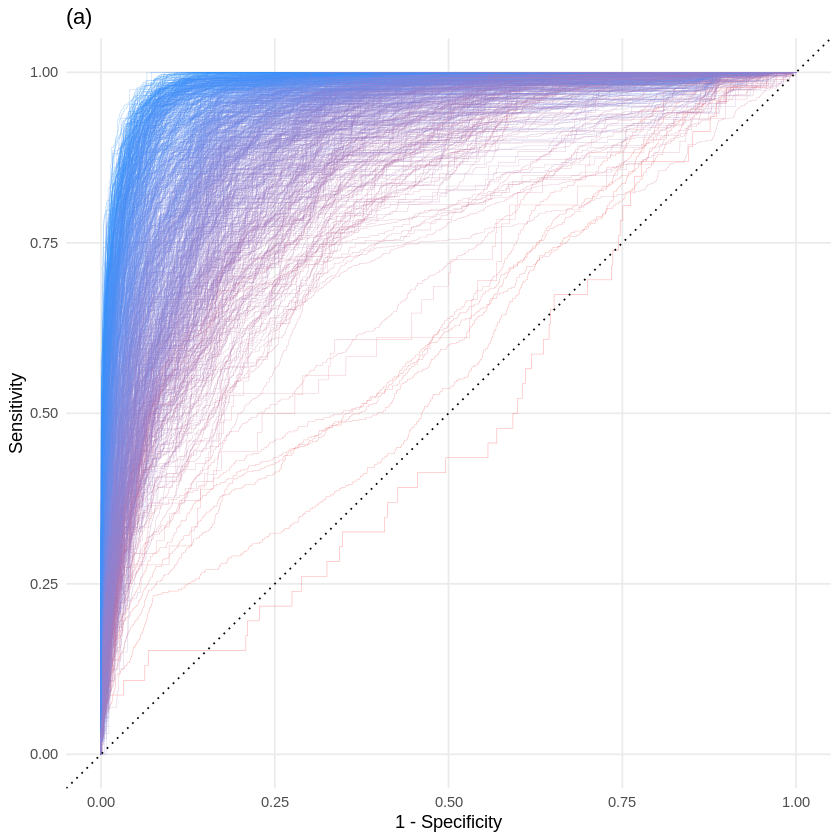

In [12]:
roc_plot <- roc_df_validation %>%
  left_join(auc_df_validation) %>%
  ggplot(aes(x = 1 - specificity, y = sensitivity, group = route_id, 
             color = .estimate)) +
  geom_path(alpha = .5, size = .1) +
  geom_abline(lty = 3) +
  theme_minimal() + 
  theme(panel.grid.minor = element_blank(), legend.position = 'none') + 
  xlab("1 - Specificity") + 
  ylab("Sensitivity") + 
  ggtitle('(a)') +
  scale_color_gradient(low = 'red', high = 'dodgerblue', 'AUC')
roc_plot

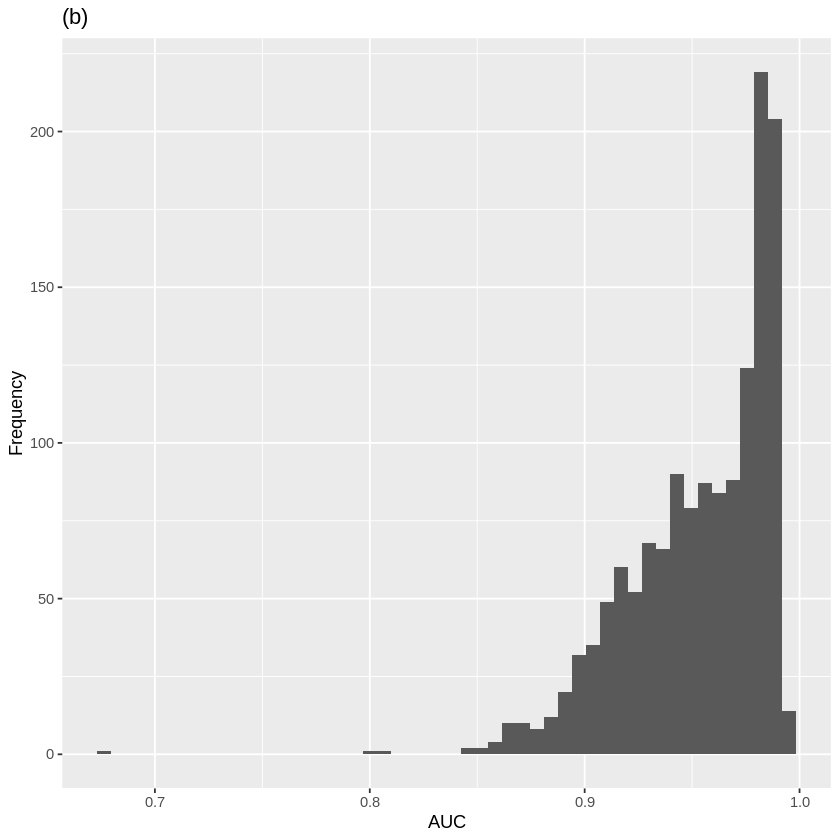

In [56]:
auc_plot <- auc_df_validation %>%
  ggplot(aes(.estimate)) + 
  geom_histogram(bins=50) + 
  xlab('AUC') + 
  ylab("Frequency") + 
  ggtitle('(b)')
auc_plot

In [57]:
packageVersion("tibble")
packageVersion("sf")
packageVersion("vctrs")

#https://community.rstudio.com/t/tibble-must-be-vectors/72888

[1] ‘3.0.4’

[1] ‘0.9.6’

[1] ‘0.3.5’

In [58]:
routes <- st_read('data/cleaned/routes.shp') %>%
  left_join(auc_df_validation) %>%
  st_transform(3174)

# https://desktop.arcgis.com/en/arcmap/10.3/manage-data/shapefiles/shapefile-file-extensions.htm
# https://gis.stackexchange.com/questions/262505/python-cant-read-shapefile
# https://stackoverflow.com/questions/61436956/set-shape-restore-shx-config-option-to-yes-to-restore-or-create-it

Reading layer `routes' from data source `/pfs/data5/home/fr/fr_fr/fr_ty14/neuralecology/data/cleaned/routes.shp' using driver `ESRI Shapefile'
Simple feature collection with 4641 features and 17 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -176.6358 ymin: 24.5977 xmax: -53.4743 ymax: 69.18743
CRS:            4326


Joining, by = "route_id"



In [59]:
ecoregions <- st_read('data/NA_CEC_Eco_Level3/NA_CEC_Eco_Level3.shp') %>%
  st_transform(st_crs(routes)) %>%
  ms_simplify

Reading layer `NA_CEC_Eco_Level3' from data source `/pfs/data5/home/fr/fr_fr/fr_ty14/neuralecology/data/NA_CEC_Eco_Level3/NA_CEC_Eco_Level3.shp' using driver `ESRI Shapefile'
Simple feature collection with 2548 features and 11 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: -4334052 ymin: -3313739 xmax: 3324076 ymax: 4267265
proj4string:    +proj=laea +lat_0=45 +lon_0=-100 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs 


In [60]:
l2_regions <- ecoregions %>%
  group_by(NA_L2KEY) %>%
  summarize

`summarise()` ungrouping output (override with `.groups` argument)



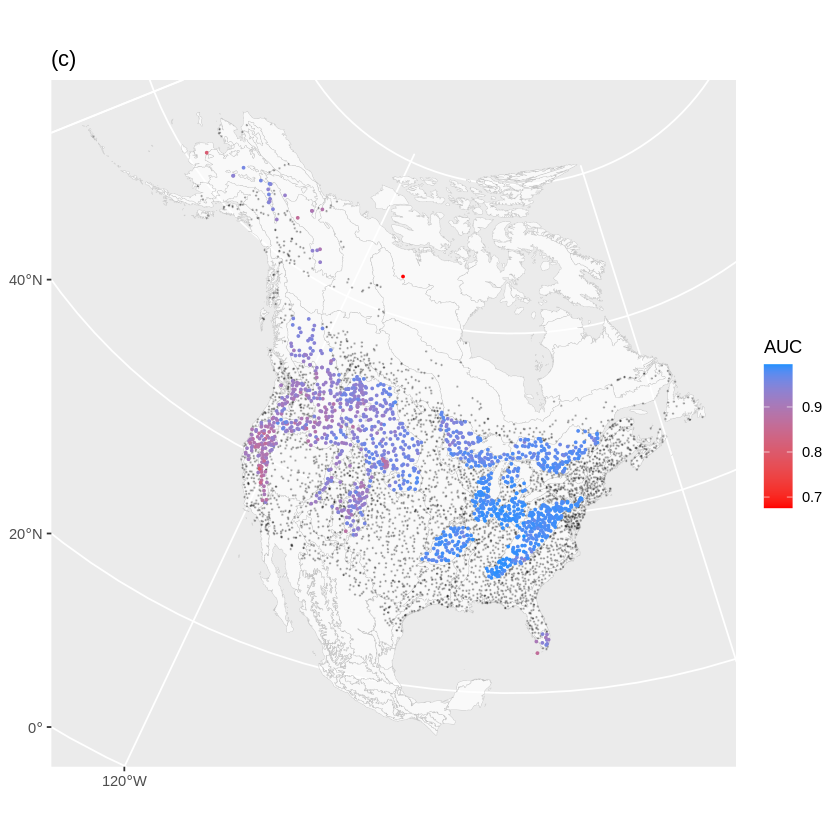

In [61]:
auc_map <- routes %>%
  ggplot() +
  geom_sf(data = l2_regions, fill = 'white', size = .1, alpha = .7, 
          color ='grey') +
  geom_sf(alpha = .2, size = .1) + 
  geom_sf(aes(color = .estimate), 
          data = filter(routes, !is.na(.estimate)), size = .4) +
  scale_color_gradient(low = 'red', high = 'dodgerblue', 'AUC') + 
  ggtitle('(c)')
auc_map

In [62]:
ggsave("out_round_1/auc-validation_map_gru.pdf", plot = auc_map + ggtitle(""), width = 5, height = 4)

p <- (roc_plot | auc_plot) / auc_map + plot_layout(heights = c(.5, 1))

p %>%
  {
    ggsave(filename = 'out_round_1/roc-validation_gru.jpg', plot = ., width = 5, height = 5)
    #ggsave(filename = 'out_round_1/roc-test_vrnn.pdf', plot = ., width = 5, height = 5)
  }


write_csv(auc_df_validation, 'out_round_1/auc_df-validation_gru.csv')
# write_csv(auc_df_training, 'out_round_1/auc_df-training_gru.csv')

In [63]:
# Compute and save validation set interval coverage stats -----------------------

coverage_df <- q_df %>%
  filter(group == 'validation') %>%
  mutate(y_less_than_pred = y < conditional_lo,
         y_more_than_pred = y > conditional_hi,
         y_in_interval = conditional_lo <= y & y <= conditional_hi) %>%
  group_by(route_id) %>%
  summarize(coverage = mean(y_in_interval), 
            y_below = mean(y_less_than_pred), 
            y_above = mean(y_more_than_pred))
write_csv(coverage_df, 'out_round_1/coverage_df-validation_gru.csv')

`summarise()` ungrouping output (override with `.groups` argument)

